In [1]:
%matplotlib notebook

In [2]:
import time

import numpy as np

#
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

#
from picos import Problem, SymmetricVariable, Constant, trace

#
import matplotlib.pyplot as plt

In [3]:
def plot_data(X, y_true, y_pred):
    # plot data
    fig = plt.figure(figsize=(8, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(*X.T, c=y_true)
    ax1.set_title('Data (original)')

    #
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(*X.T, c=y_pred)
    ax2.set_title('Data (k-means)')
    plt.show()
    

def plot_block_matrices(C_original, C):
    # plot block matrix
    fig = plt.figure(figsize=(8, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(C_original)
    ax1.set_title('Cluster block matrix (original)')
    
    #
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(C)
    ax2.set_title('Cluster block matrix (k-means)')
    plt.show()

In [4]:
def cluster_block_diagonal(labels):
    
    #
    # create cluster block-matrix (formula (1))
    C = np.zeros((labels.shape[0], labels.shape[0]))
    for label in np.unique(labels):
        cluster = (labels == label).astype(np.int)[:,np.newaxis]
        cluster = np.dot(cluster, cluster.T) / np.sum(cluster)
        C += cluster
        
    return C

In [5]:
def setup_problem(D, C, k):
    
    # setup SDP problem
    problem = Problem()
    X_pi = SymmetricVariable('X', D.shape)
    D_pi = Constant('D', D)
    C_pi = Constant('C', C)
    vec1 = Constant('vec1', np.ones((D.shape[0])))

    # clustering loss (formula (7))
    loss = np.trace(np.dot(D.T, C)) # / 2

    # objective (formula (11))
    problem.set_objective('min', (C_pi | X_pi))

    # Formula (10)
    C1 = problem.add_constraint(X_pi >> 0) #  positive semidefnite
    C2 = problem.add_constraint(X_pi >= 0.)
    C3 = problem.add_constraint(trace(X_pi) == k)
    C4 = problem.add_constraint(X_pi * vec1 == vec1)

    # Formula (11)
    # C5 = problem.add_constraint((2*k - 2*(D | X_pi)) <= loss)
    C5 = problem.add_constraint((D | X_pi) <= loss)
    
    return problem

## Stable clustering (K_true=2, K=2)

<IPython.core.display.Javascript object>


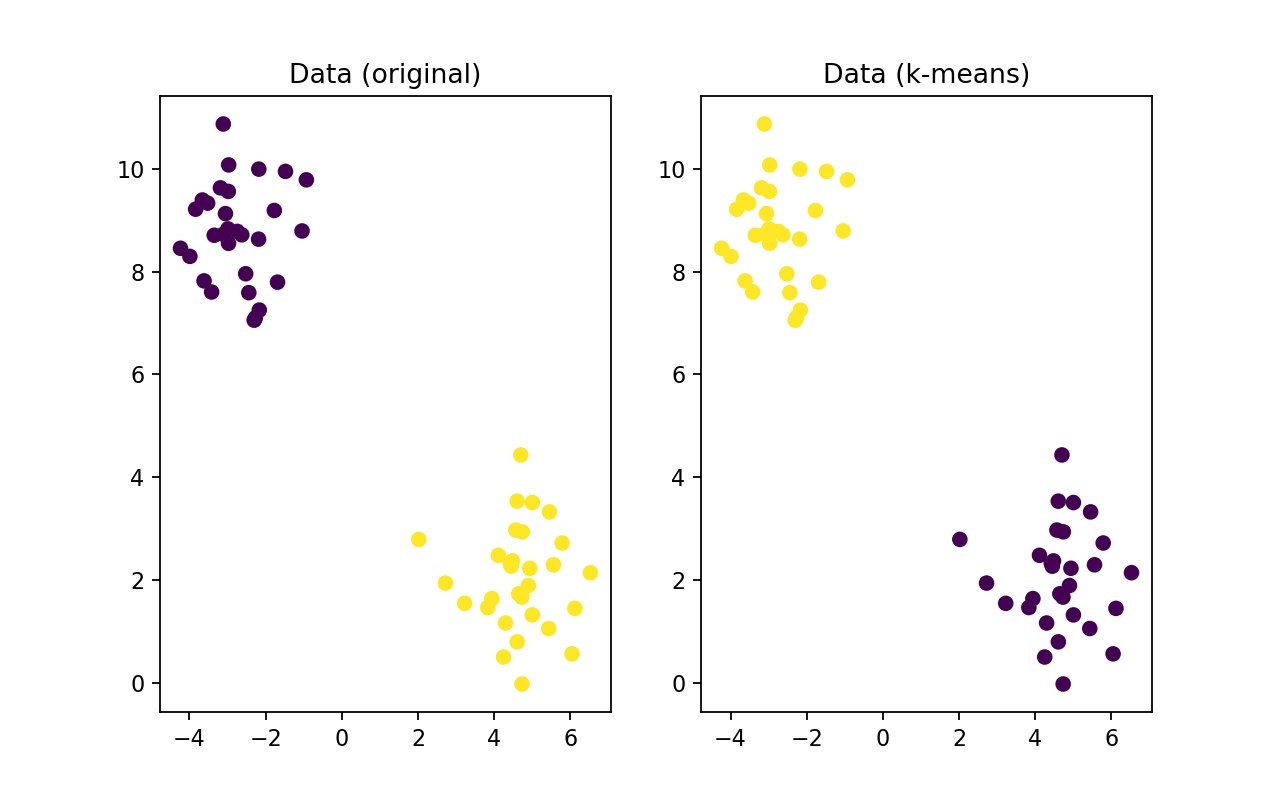

<IPython.core.display.Javascript object>


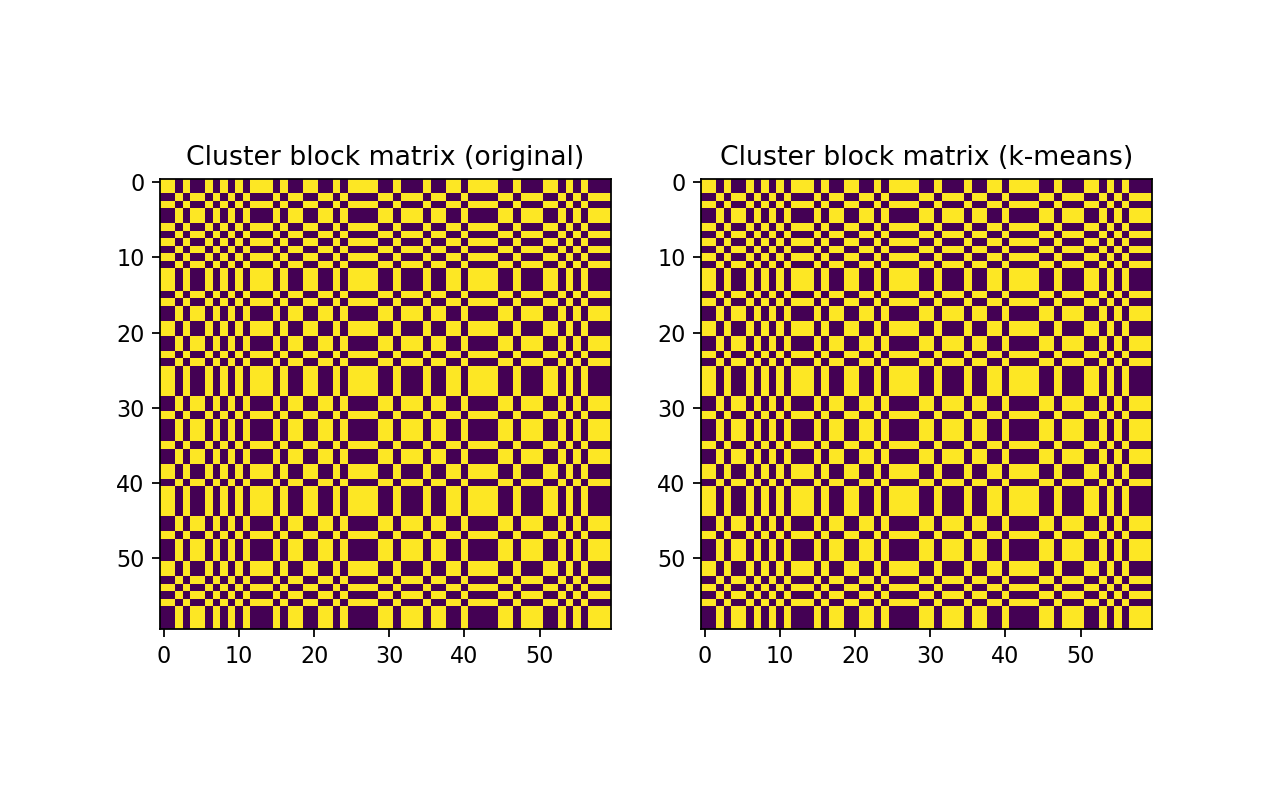

In [6]:
# generate random data
X, y = make_blobs(n_samples=60, n_features=2, centers=2, random_state=42)

# distance matrix (n, n)
D = euclidean_distances(X)

# problem dimensions
N, dim = X.shape

# k-means clustering
k = 2
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
labels = kmeans.labels_

# bounds (2.1 Preliminaries and definitions)
_, label_counts = np.unique(labels, return_counts=True)
p_min = np.min(label_counts) / N
p_max = np.max(label_counts) / N

# create cluster block-matrix (formula (1))
C_original = cluster_block_diagonal(y)
C = cluster_block_diagonal(labels)

# plot data
plot_data(X, y, labels)

# plot block matrix
plot_block_matrices(C_original, C)

------------------------------
Semidefinite Program
  minimize ⟨C, X⟩
  over
    60×60 symmetric variable X
  subject to
    X ≽ 0
    X ≥ 0
    tr(X) = 2
    X·vec1 = vec1
    ⟨[60×60], X⟩ ≤ 96.9858
------------------------------
Clustering is stable (delta = 2.000, duration 56s).


<IPython.core.display.Javascript object>


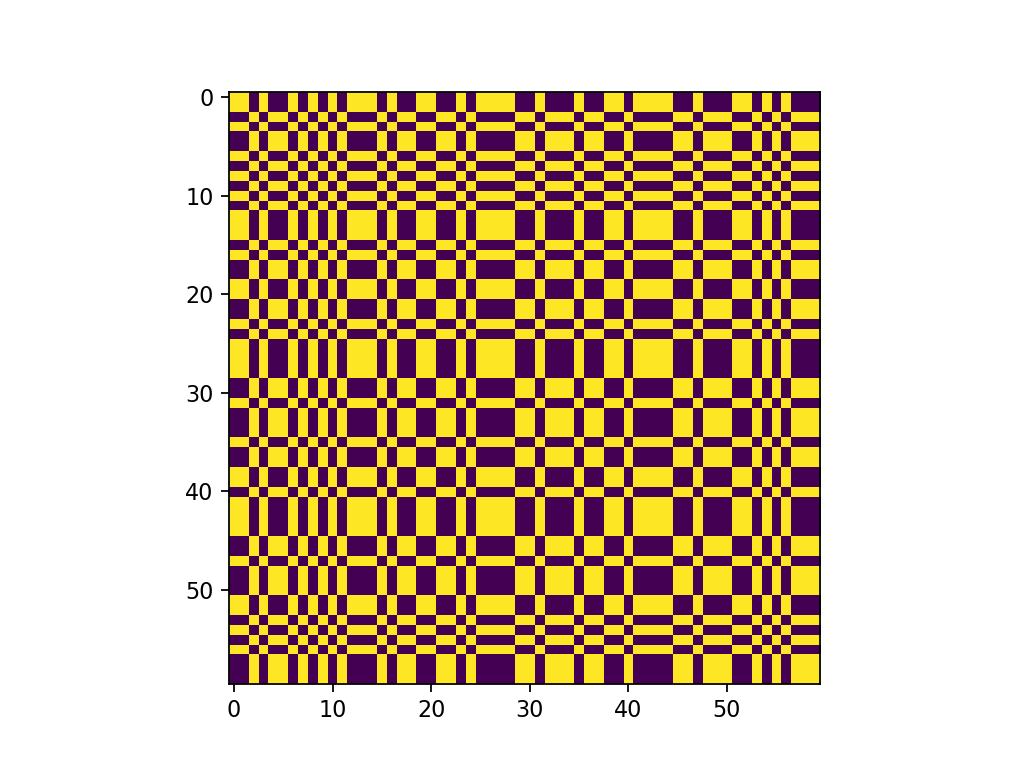

In [7]:
# define problem
problem = setup_problem(D, C, k)
print(problem)

# solve relaxation problem
solution = problem.solve(primals=None, duals=None, verbosity=0)
delta, duration = solution.value, solution.searchTime
eps = (k - delta) * p_max

if eps <= p_min:
    print('Clustering is stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
else:
    print('Clustering is NOT stable (delta = {:.3f}, duration {}s).'.format(
        delta,
        int(duration)
    ))
    
#
fig = plt.figure()
X_pi = problem.get_variable('X')
plt.imshow(np.array(X_pi.value))

## Instable clustering (K_true=2, K=3)

<IPython.core.display.Javascript object>


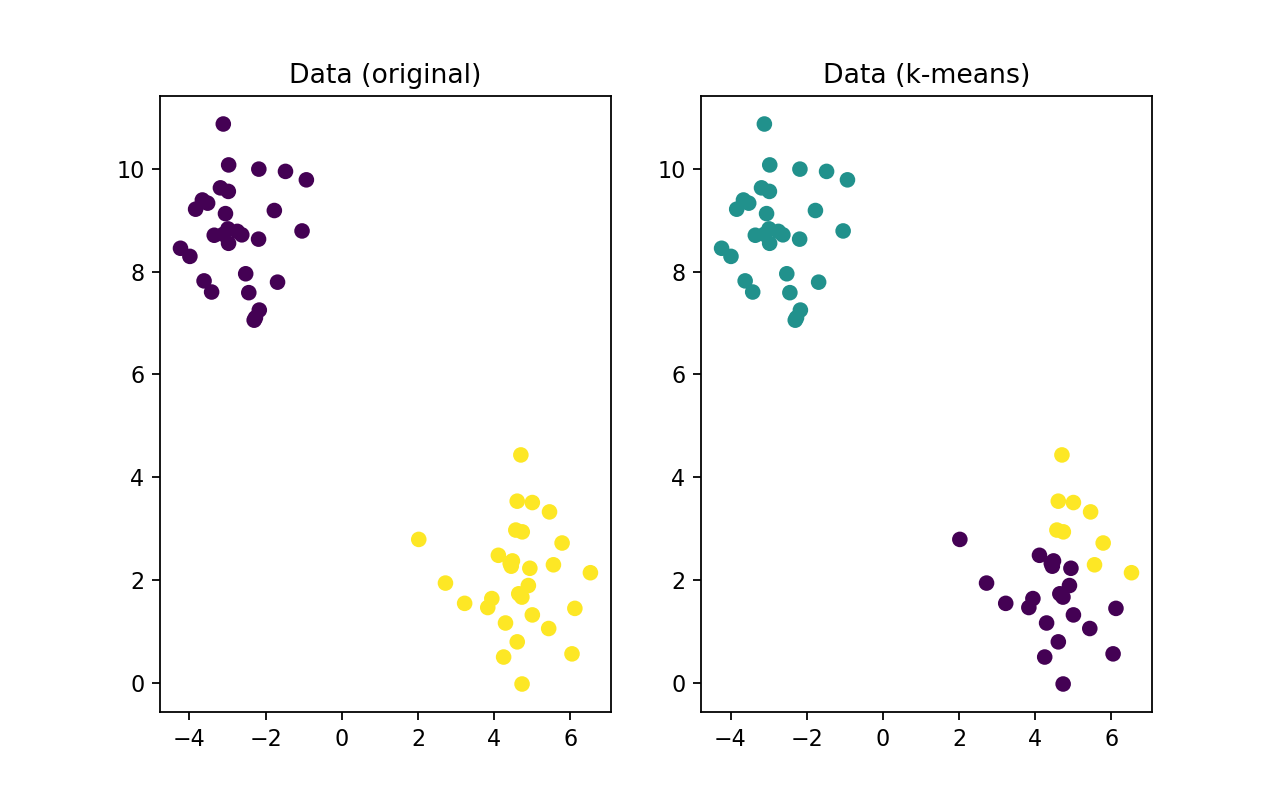

<IPython.core.display.Javascript object>


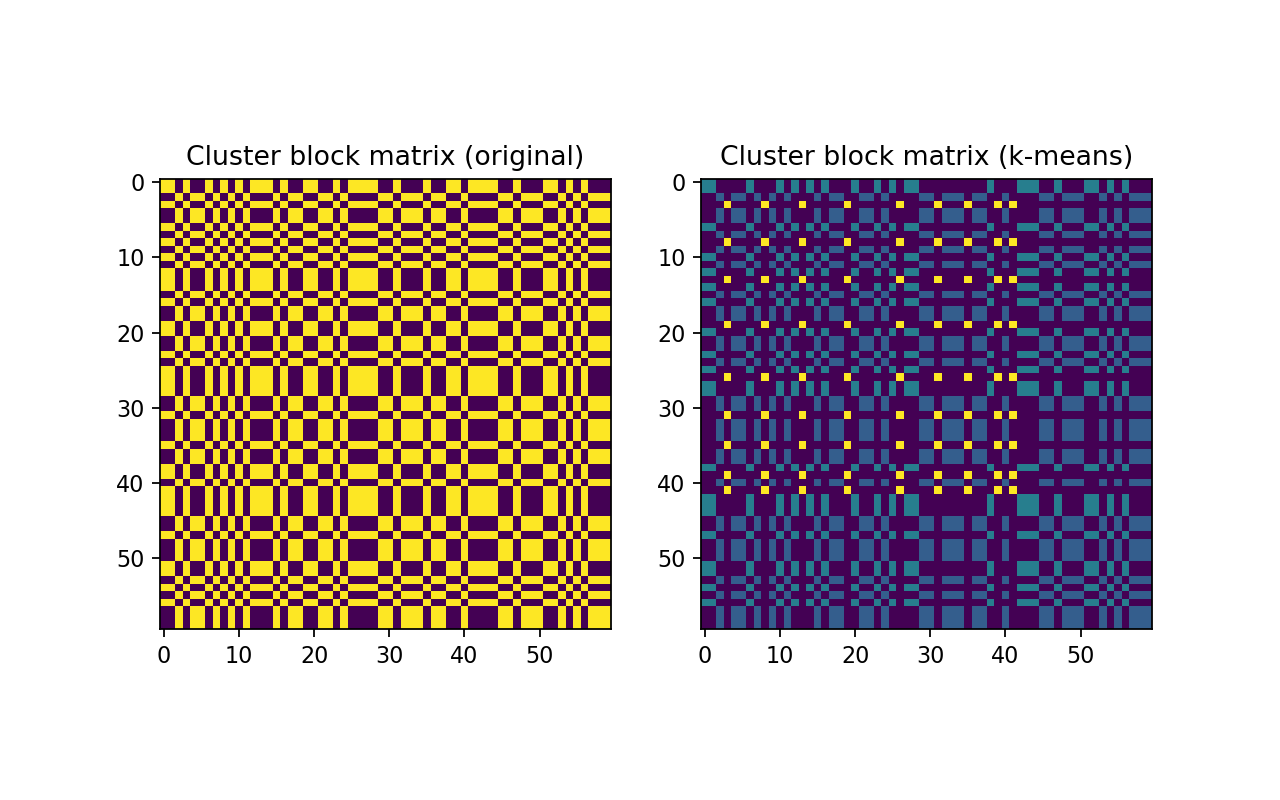

In [8]:
# generate random data
X, y = make_blobs(n_samples=60, n_features=2, centers=2, random_state=42)

# distance matrix (n, n)
D = euclidean_distances(X)

# problem dimensions
N, dim = X.shape

# k-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
labels = kmeans.labels_

# bounds (2.1 Preliminaries and definitions)
_, label_counts = np.unique(labels, return_counts=True)
p_min = np.min(label_counts) / N
p_max = np.max(label_counts) / N

# create cluster block-matrix (formula (1))
C_original = cluster_block_diagonal(y)
C = cluster_block_diagonal(labels)

# plot data
plot_data(X, y, labels)

# plot block matrix
plot_block_matrices(C_original, C)

------------------------------
Semidefinite Program
  minimize ⟨C, X⟩
  over
    60×60 symmetric variable X
  subject to
    X ≽ 0
    X ≥ 0
    tr(X) = 3
    X·vec1 = vec1
    ⟨[60×60], X⟩ ≤ 86.1596
------------------------------
Clustering is NOT stable (delta = 1.977, duration 87s).


<IPython.core.display.Javascript object>


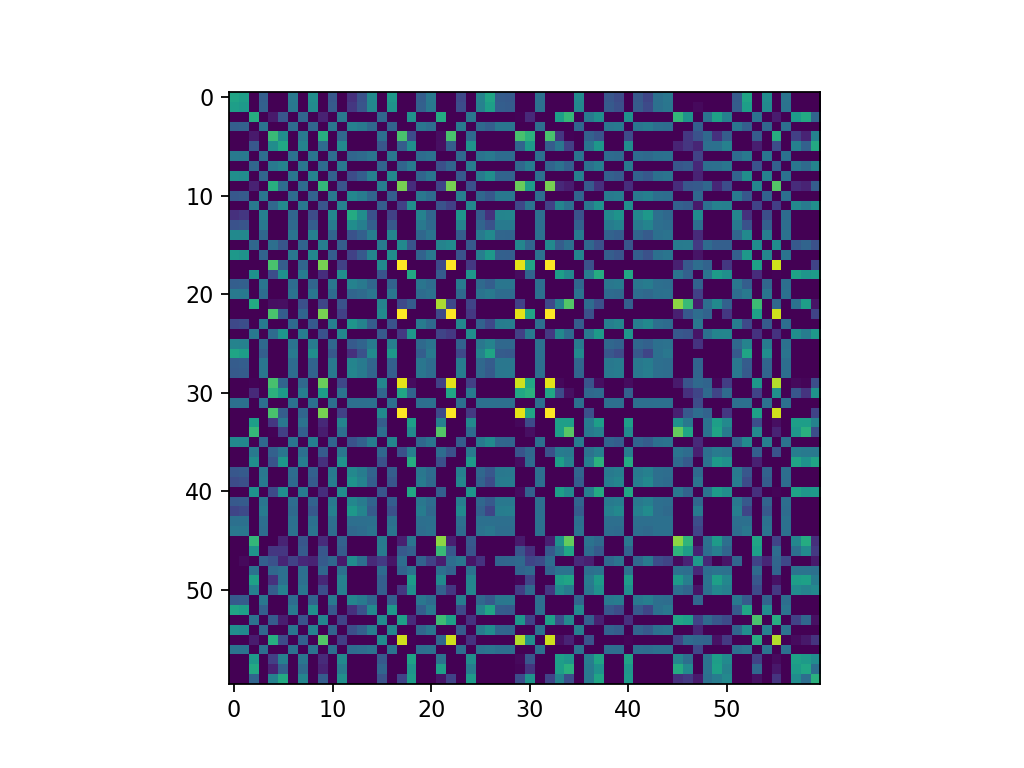

In [9]:
# define problem
problem = setup_problem(D, C, k)
print(problem)

# solve relaxation problem
solution = problem.solve(primals=None, duals=None, verbosity=0)
delta, duration = solution.value, solution.searchTime
eps = (k - delta) * p_max

if eps <= p_min:
    print('Clustering is stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
else:
    print('Clustering is NOT stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
    
#
fig = plt.figure()
X_pi = problem.get_variable('X')
plt.imshow(np.array(X_pi.value))

## Instable clustering anisotropical (K_true=2, K=2)

<IPython.core.display.Javascript object>


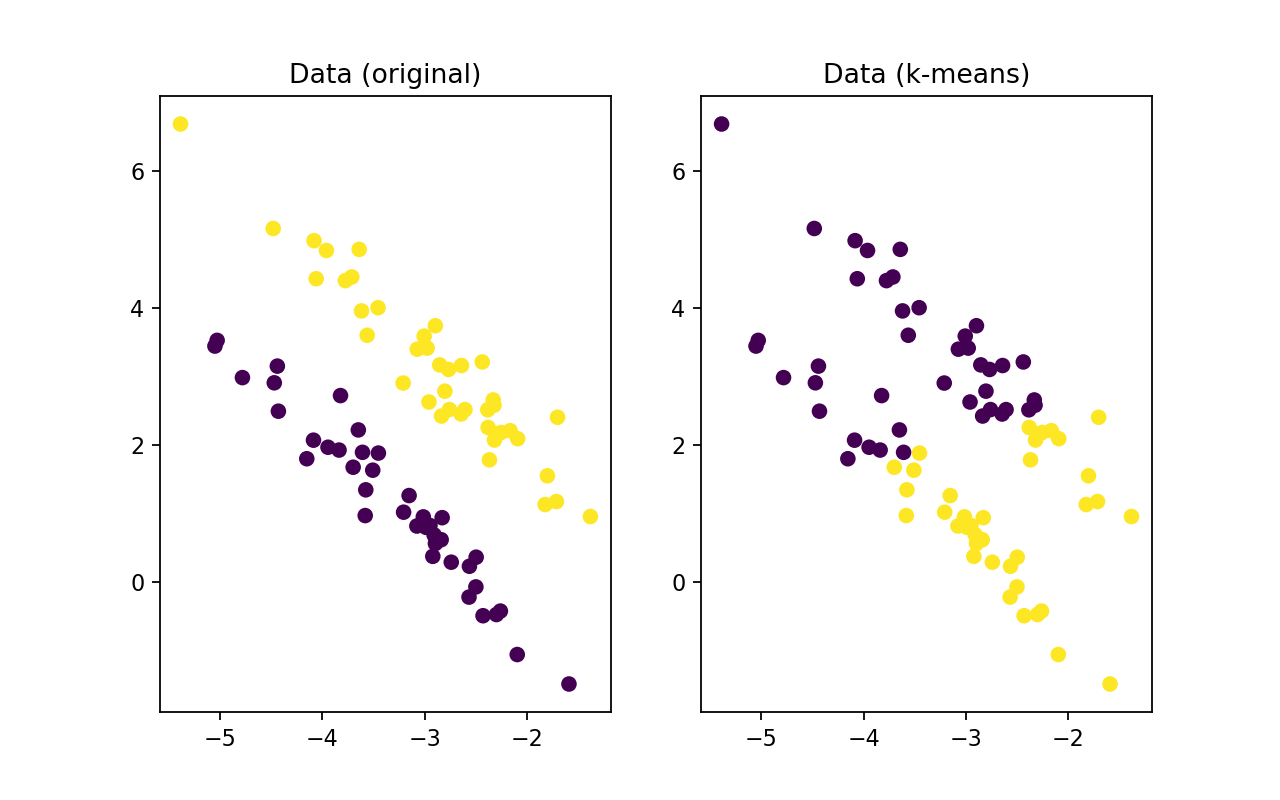

<IPython.core.display.Javascript object>


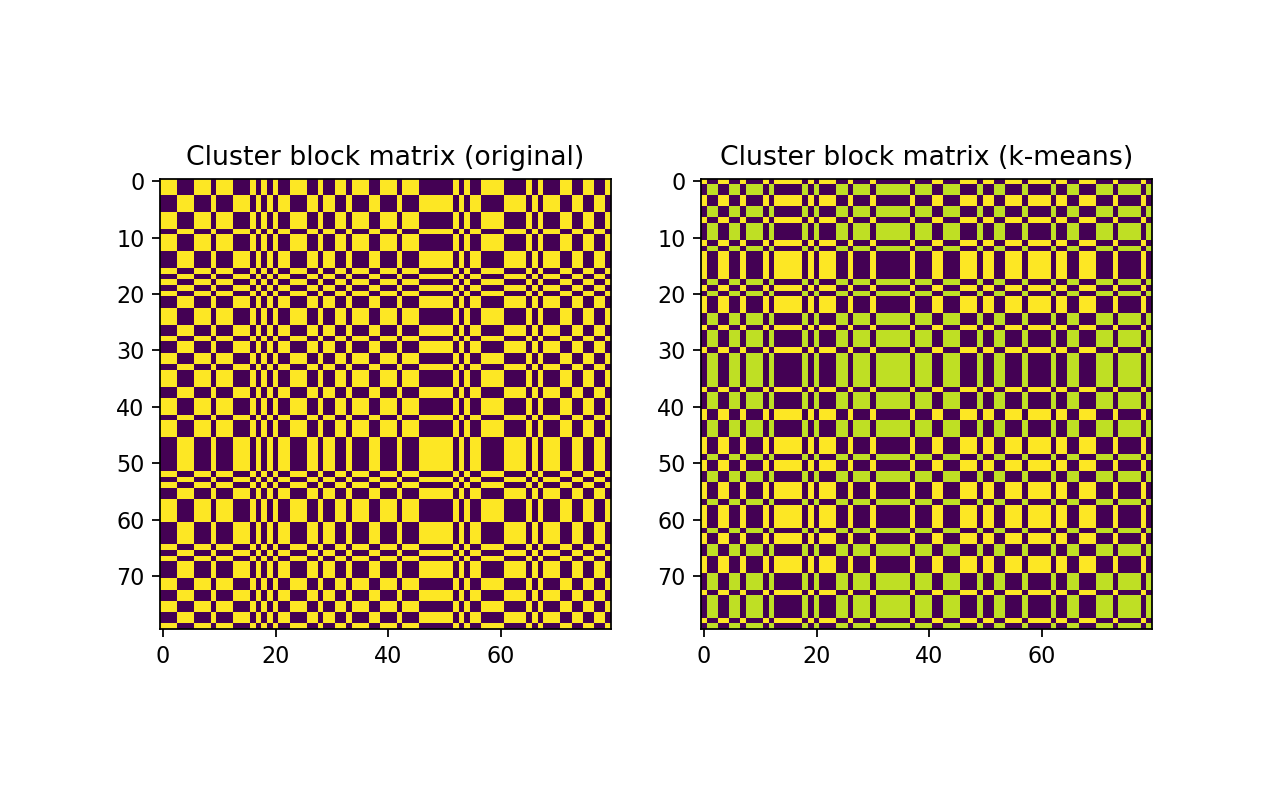

In [21]:
# generate random data
X, y = make_blobs(n_samples=80, n_features=2, centers=2, random_state=170)

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X = np.dot(X, transformation)

# distance matrix (n, n)
D = euclidean_distances(X)

# problem dimensions
N, dim = X.shape

# k-means clustering
k = 2
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
labels = kmeans.labels_

# bounds (2.1 Preliminaries and definitions)
_, label_counts = np.unique(labels, return_counts=True)
p_min = np.min(label_counts) / N
p_max = np.max(label_counts) / N

# create cluster block-matrix (formula (1))
C_original = cluster_block_diagonal(y)
C = cluster_block_diagonal(labels)

# plot data
plot_data(X, y, labels)

# plot block matrix
plot_block_matrices(C_original, C)

------------------------------
Semidefinite Program
  minimize ⟨C, X⟩
  over
    80×80 symmetric variable X
  subject to
    X ≽ 0
    X ≥ 0
    tr(X) = 2
    X·vec1 = vec1
    ⟨[80×80], X⟩ ≤ 117.399
------------------------------
Clustering is stable (delta = 1.322, duration 524s).


<IPython.core.display.Javascript object>


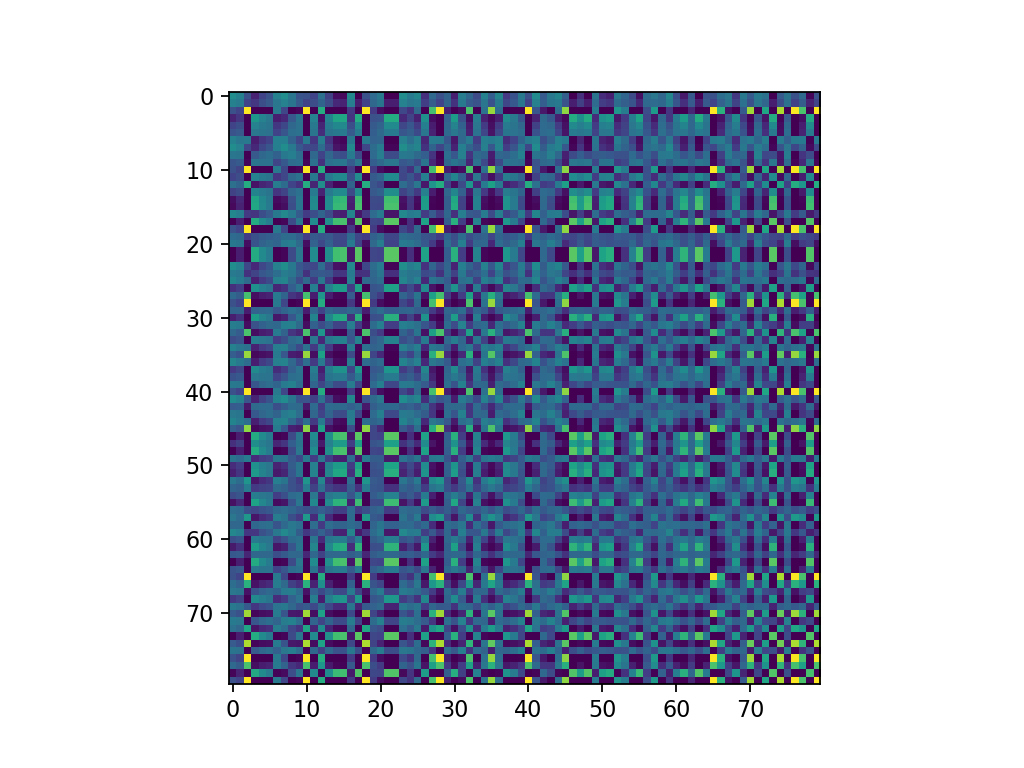

In [22]:
# define problem
problem = setup_problem(D, C, k)
print(problem)

# solve relaxation problem
solution = problem.solve(primals=None, duals=None, verbosity=0)
delta, duration = solution.value, solution.searchTime
eps = (k - delta) * p_max

if eps <= p_min:
    print('Clustering is stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
else:
    print('Clustering is NOT stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
    
#
fig = plt.figure()
X_pi = problem.get_variable('X')
plt.imshow(np.array(X_pi.value))

## Stable clustering (K_true=4, K=4)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


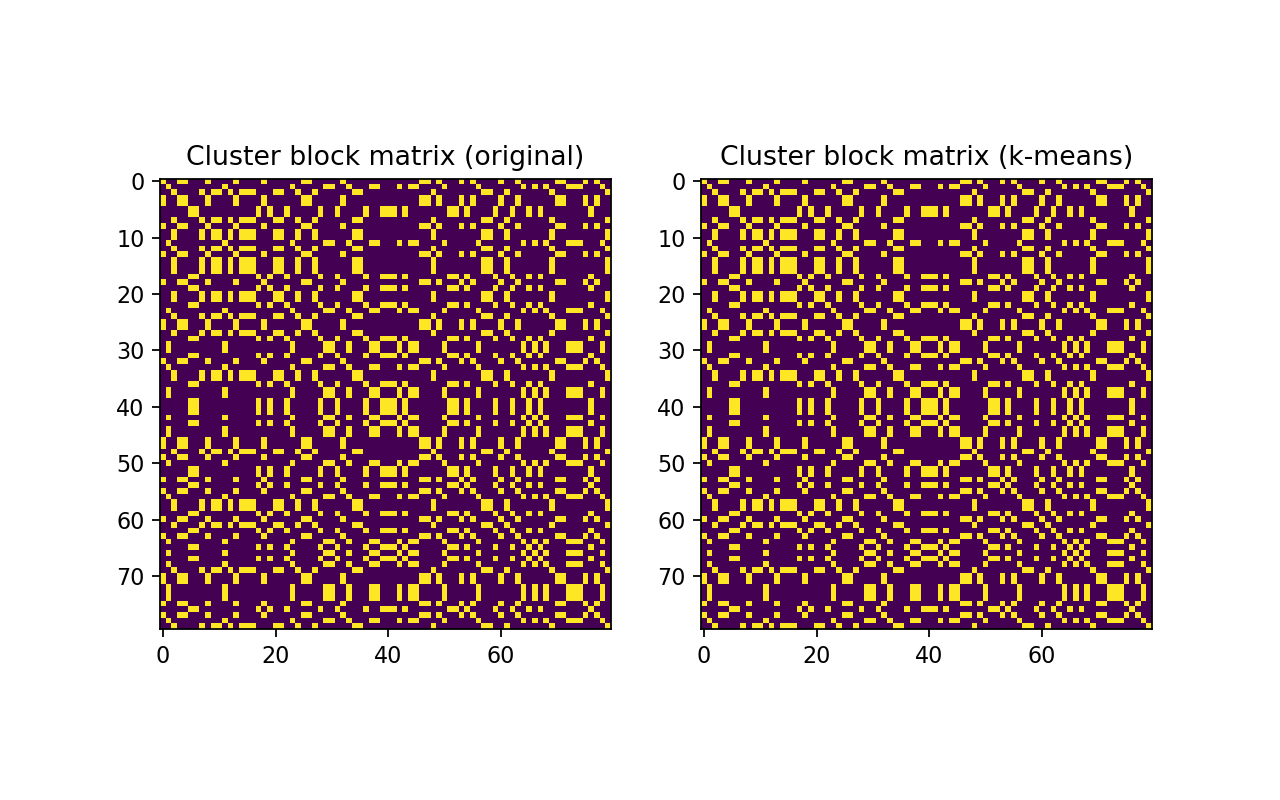

In [10]:
# generate random data
X, y = make_blobs(n_samples=80, n_features=2, centers=4, random_state=42)

# distance matrix (n, n)
D = euclidean_distances(X)

# problem dimensions
N, dim = X.shape

# k-means clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
labels = kmeans.labels_

# bounds (2.1 Preliminaries and definitions)
_, label_counts = np.unique(labels, return_counts=True)
p_min = np.min(label_counts) / N
p_max = np.max(label_counts) / N

# create cluster block-matrix (formula (1))
C_original = cluster_block_diagonal(y)
C = cluster_block_diagonal(labels)

# plot data
plot_data(X, y, labels)

# plot block matrix
plot_block_matrices(C_original, C)

In [11]:
# define problem
problem = setup_problem(D, C, k)
print(problem)

# solve relaxation problem
solution = problem.solve(primals=None, duals=None, verbosity=0)
delta, duration = solution.value, solution.searchTime
eps = (k - delta) * p_max

if eps <= p_min:
    print('Clustering is stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
else:
    print('Clustering is NOT stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
    
#
fig = plt.figure()
X_pi = problem.get_variable('X')
plt.imshow(np.array(X_pi.value))

------------------------------
Semidefinite Program
  minimize ⟨C, X⟩
  over
    80×80 symmetric variable X
  subject to
    X ≽ 0
    X ≥ 0
    tr(X) = 4
    X·vec1 = vec1
    ⟨[80×80], X⟩ ≤ 129.264
------------------------------
Clustering is stable (delta = 4.000, duration 466s).


<IPython.core.display.Javascript object>

## Instable clustering (K_true=4, K=3)

<IPython.core.display.Javascript object>


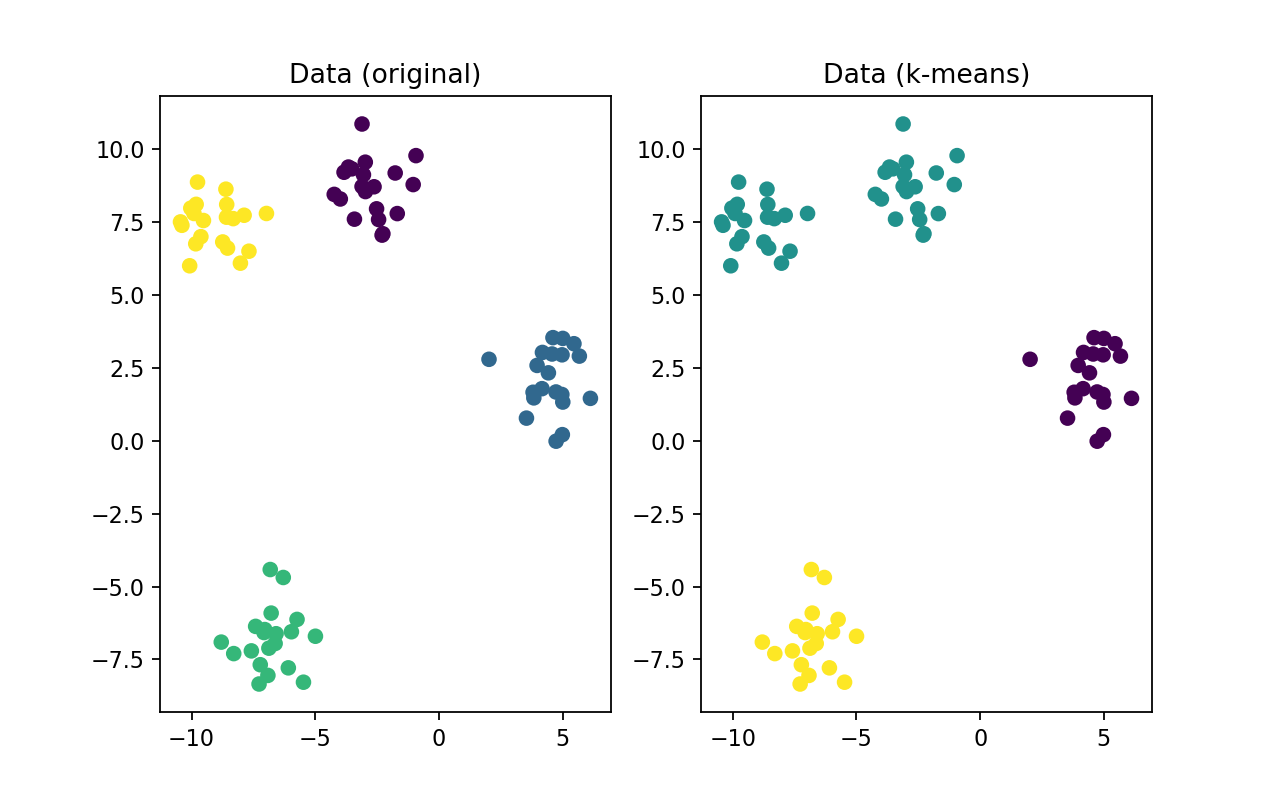

<IPython.core.display.Javascript object>


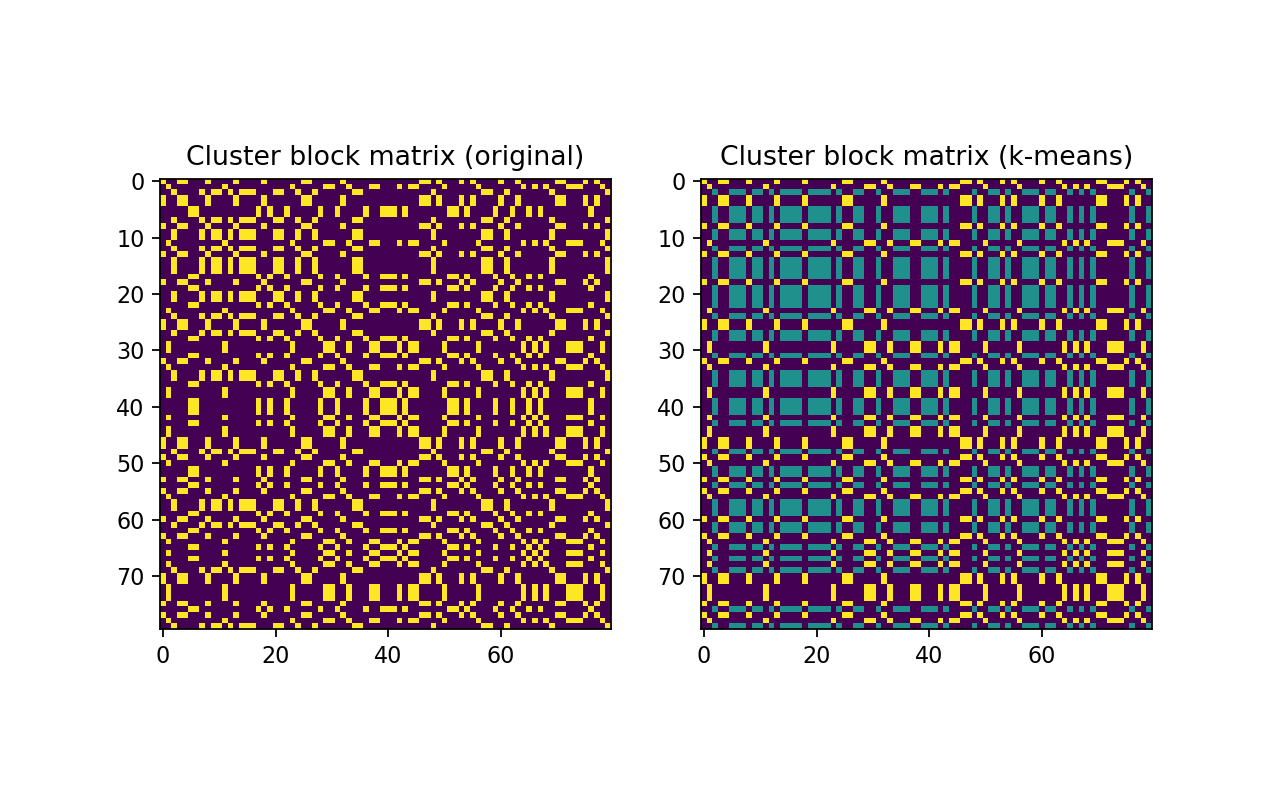

In [12]:
# generate random data
X, y = make_blobs(n_samples=80, n_features=2, centers=4, random_state=42)

# distance matrix (n, n)
D = euclidean_distances(X)

# problem dimensions
N, dim = X.shape

# k-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
labels = kmeans.labels_

# bounds (2.1 Preliminaries and definitions)
_, label_counts = np.unique(labels, return_counts=True)
p_min = np.min(label_counts) / N
p_max = np.max(label_counts) / N

# create cluster block-matrix (formula (1))
C_original = cluster_block_diagonal(y)
C = cluster_block_diagonal(labels)

# plot data
plot_data(X, y, labels)

# plot block matrix
plot_block_matrices(C_original, C)

In [13]:
# define problem
problem = setup_problem(D, C, k)
print(problem)

# solve relaxation problem
solution = problem.solve(primals=None, duals=None, verbosity=0)
delta, duration = solution.value, solution.searchTime
eps = (k - delta) * p_max

if eps <= p_min:
    print('Clustering is stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
else:
    print('Clustering is NOT stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
    
#
fig = plt.figure()
X_pi = problem.get_variable('X')
plt.imshow(np.array(X_pi.value))

------------------------------
Semidefinite Program
  minimize ⟨C, X⟩
  over
    80×80 symmetric variable X
  subject to
    X ≽ 0
    X ≥ 0
    tr(X) = 3
    X·vec1 = vec1
    ⟨[80×80], X⟩ ≤ 228.258
------------------------------
Clustering is stable (delta = 3.000, duration 521s).


<IPython.core.display.Javascript object>

## Instable clustering (K_true=4, K=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


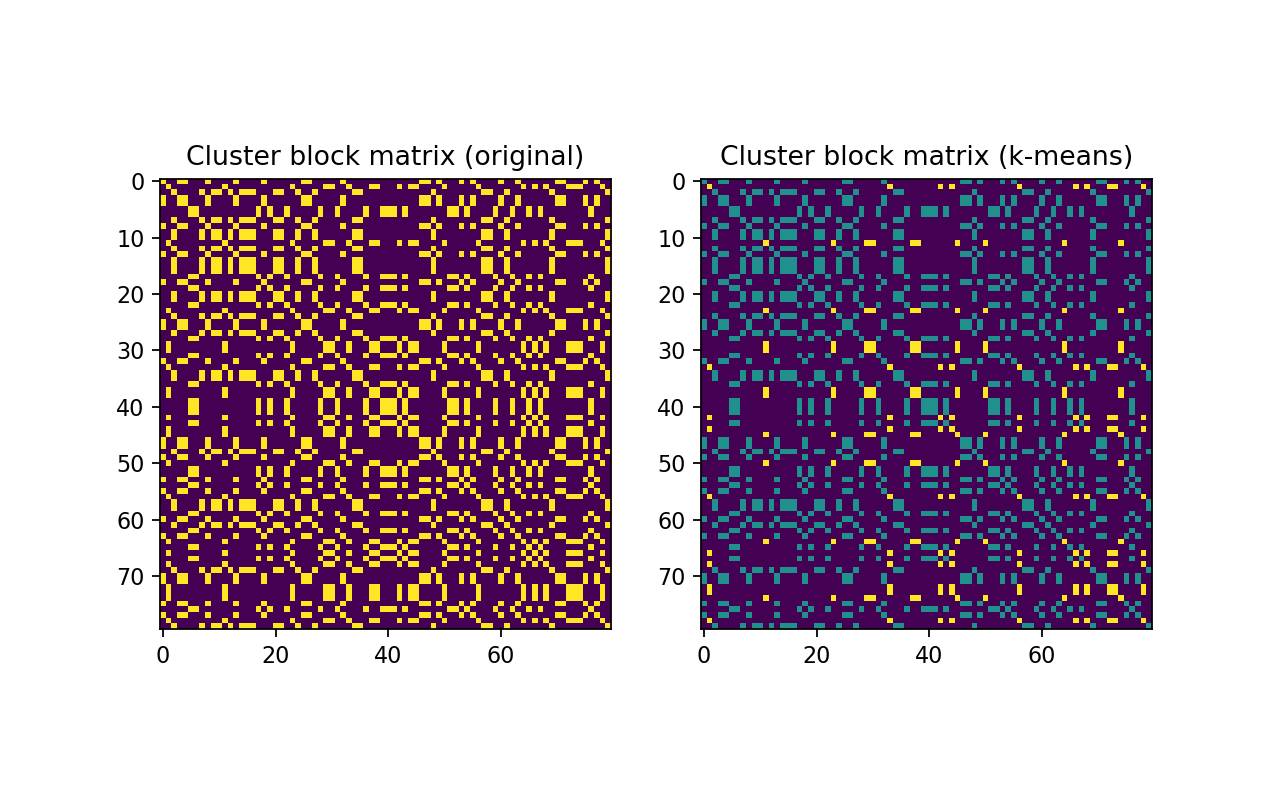

In [15]:
# generate random data
X, y = make_blobs(n_samples=80, n_features=2, centers=4, random_state=42)

# distance matrix (n, n)
D = euclidean_distances(X)

# problem dimensions
N, dim = X.shape

# k-means clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
labels = kmeans.labels_

# bounds (2.1 Preliminaries and definitions)
_, label_counts = np.unique(labels, return_counts=True)
p_min = np.min(label_counts) / N
p_max = np.max(label_counts) / N

# create cluster block-matrix (formula (1))
C_original = cluster_block_diagonal(y)
C = cluster_block_diagonal(labels)

# plot data
plot_data(X, y, labels)

# plot block matrix
plot_block_matrices(C_original, C)

In [16]:
# define problem
problem = setup_problem(D, C, k)
print(problem)

# solve relaxation problem
solution = problem.solve(primals=None, duals=None, verbosity=0)
delta, duration = solution.value, solution.searchTime
eps = (k - delta) * p_max

if eps <= p_min:
    print('Clustering is stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
else:
    print('Clustering is NOT stable (delta = {:.3f}, duration {}s).'.format(
        delta, 
        int(duration)
    ))
    
#
fig = plt.figure()
X_pi = problem.get_variable('X')
plt.imshow(np.array(X_pi.value))

------------------------------
Semidefinite Program
  minimize ⟨C, X⟩
  over
    80×80 symmetric variable X
  subject to
    X ≽ 0
    X ≥ 0
    tr(X) = 5
    X·vec1 = vec1
    ⟨[80×80], X⟩ ≤ 119.308
------------------------------
Clustering is NOT stable (delta = 3.963, duration 420s).


<IPython.core.display.Javascript object>